# Modèles ARIMA et SARIMA sur le log de la production d'électricité (désaisonnalisé)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()
%matplotlib inline

#### Chargement des données et différenciation

In [2]:
FolderNames = ["BoulangeriePatisserie", "GlacesSorbets", "Fromage", "Electricite"]

df = pd.read_csv(
   "./{}/valeurs_mensuelles.csv".format(FolderNames[0]),
    sep=";",
    skiprows=[1, 2],
    index_col="Libellé",
    parse_dates=["Libellé"])
df.columns = [FolderNames[0],"ToDelete"]
del(df["ToDelete"])


for i,name in enumerate(FolderNames):
    if i>0:
        temp = pd.read_csv(
       "./{}/valeurs_mensuelles.csv".format(name),
        sep=";",
        skiprows=[1, 2],
        index_col="Libellé",
        parse_dates=["Libellé"])
        temp.columns = [FolderNames[i],"ToDelete"]
        del(temp["ToDelete"])
        df = pd.merge(df, temp, on='Libellé')

In [8]:
dfE = pd.Series(df.Electricite)
log_dfE = np.log(dfE)

In [9]:
series = pd.Series(log_dfE) 
X = series.values[::-1]
log_dfE_diff = pd.DataFrame(index=series.index[-13::-1], columns=[""])
for i in range(12, len(X)):
    value = X[i] - X[i - 12]
    log_dfE_diff.iloc[i-12,] = value
    
log_dfE_diff = pd.Series(log_dfE_diff[""].astype("float"))

## 1. Etude et comparaison de différents modèles ARIMA et SARIMA

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox # test portmanteau
from statsmodels.tsa.statespace.sarimax import SARIMAX

### 1.1. Sélection de modèles ARIMA - Etude des fonctions d'autocorrélogrammes

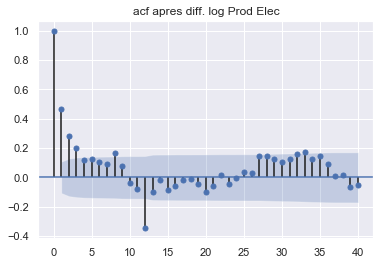

In [10]:
plt.figure(figsize=(10,10))
plot_acf(log_dfE_diff.values, lags=60, title="acf apres diff. log Prod Elec")
plt.show()

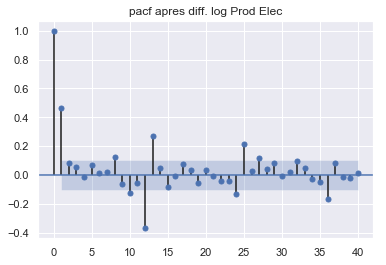

In [11]:
plt.figure(figsize=(10,10))
plot_pacf(log_dfE_diff.values, lags=60, title="pacf apres diff. log Prod Elec")
plt.show()

**Commentaires:** Il y a encore des autocorrélations (totales et partielles) significatives à des seuils encore élevé. Il est peut-être nécessaire de désaisonnaliser une seconde fois ou de fit un SARIMA ? Ce détail de côté, au regard des autocorrélogrammes on serait tenté de choisir comme ordre p=1 et q=3. 

In [16]:
arima_model = ARIMA(log_dfE_diff, order=(1,0,3)).fit()
arima_model.summary()

/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  337
Model:                     ARMA(1, 3)   Log Likelihood                 583.094
Method:                       css-mle   S.D. of innovations              0.043
Date:                Mon, 08 Apr 2019   AIC                          -1154.189
Time:                        22:47:25   BIC                          -1131.268
Sample:                    01-01-1991   HQIC                         -1145.053
                         - 01-01-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0116      0.006      2.006      0.046       0.000       0.023
ar.L1.y        0.7773      0.129      6.035      0.000       0.525       1.030
ma.L1.y       -0.3602      0.144     -2.505      0.013      -0.642      -0.078
ma.L2.y       -0.0730      0.085     -0.863      0.389      -0.239       0.093
ma.L3.y       -0.0140      0.068     -0.205      0.838      -0.148       0.120
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2865           +0.0000j            1.2865            0.0000
MA.1            1.8436           -0.0000j            1.8436           -0.0000
MA.2           -3.5274           -5.1247j            6.2214           -0.3459
MA.3           -3.5274           +5.1247j            6.2214            0.3459
-----------------------------------------------------------------------------
"""

**Commentaires:** Les deux derniers coefficients de la partie MA ne sont pas significatifs.

In [45]:
arima_model = ARIMA(log_dfE_diff, order=(1,0,1)).fit()
arima_model.summary()

/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  337
Model:                     ARMA(1, 1)   Log Likelihood                 582.818
Method:                       css-mle   S.D. of innovations              0.043
Date:                Mon, 08 Apr 2019   AIC                          -1157.636
Time:                        23:02:14   BIC                          -1142.356
Sample:                    01-01-1991   HQIC                         -1151.546
                         - 01-01-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0114      0.005      2.140      0.033       0.001       0.022
ar.L1.y        0.6762      0.091      7.442      0.000       0.498       0.854
ma.L1.y       -0.2621      0.119     -2.209      0.028      -0.495      -0.029
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4788           +0.0000j            1.4788            0.0000
MA.1            3.8158           +0.0000j            3.8158            0.0000
-----------------------------------------------------------------------------
"""

**Commentaires:** Tous les coefficients sont significatifs et l'AIC et le BIC sont meilleurs. Il faudrait vérifier les résidus (qq-plot, test portmanteau).

In [46]:
residuals = [log_dfE_diff[i]-arima_model.predict()[i] for i in range(len(log_dfE_diff))] 

/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [44]:
print(acorr_ljungbox(residuals, lags=40)[1])

[3.92290133e-36 8.91812244e-44 6.40983273e-46 6.55551964e-46
 1.21897614e-45 3.06232718e-45 5.67213039e-45 3.77134157e-45
 1.83081426e-44 1.39028806e-44 6.85301077e-49 1.42263599e-60
 2.68592973e-65 4.16696910e-66 2.94149230e-67 5.90629611e-68
 5.93291017e-68 6.63317537e-68 1.42934674e-68 4.52063157e-70
 1.28476562e-70 2.51332310e-70 3.59109987e-70 8.93986697e-70
 3.53797900e-69 1.27932697e-68 4.05751072e-69 2.49204081e-70
 4.99684911e-71 1.88954358e-71 2.22475520e-72 2.96016205e-74
 1.96275678e-76 8.70766693e-78 9.40602150e-79 1.11952652e-78
 4.11773225e-78 1.04768723e-77 4.50008020e-78 1.97959842e-78]


### 1.2. Sélection de modèles SARIMA - Etude des fonctions d'autocorrélogrammes

On se resert des fonctions d'autocorrélations totales et partielles précédentes pour identifier les ordre (p,d,q) et (P,D,Q):

In [50]:
sarima_model = SARIMAX(log_dfE_diff, order=(1,0,3), seasonal_order=(3,0,1,12)).fit()
sarima_model.summary()

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  337
Model:             SARIMAX(1, 0, 3)x(3, 0, 1, 12)   Log Likelihood                 659.834
Date:                            Mon, 08 Apr 2019   AIC                          -1301.667
Time:                                    23:06:24   BIC                          -1267.287
Sample:                                01-01-1991   HQIC                         -1287.964
                                     - 01-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9715      0.014     70.674      0.000       0.945       0.998
ma.L1         -0.4847      0.046    -10.447      0.000      -0.576      -0.394
ma.L2         -0.1023      0.057     -1.789      0.074      -0.214       0.010
ma.L3         -0.1262      0.051     -2.485      0.013      -0.226      -0.027
ar.S.L12      -0.5484      0.184     -2.986      0.003      -0.908      -0.188
ar.S.L24      -0.3809      0.152     -2.512      0.012      -0.678      -0.084
ar.S.L36      -0.1535      0.101     -1.518      0.129      -0.352       0.045
ma.S.L12      -0.2912      0.197     -1.476      0.140      -0.678       0.095
sigma2         0.0011   7.49e-05     15.016      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       38.27   Jarque-Bera (JB):                23.82
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                             0.12
Prob(H) (two-sided):                  0.12   Kurtosis:                         4.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Commentaires:** Certains coefs ne sont pas significatifs, en revanche la statistique Ljung-Box confirme que les résidus sont indépendants, mais le test Jarque-Bera conduit à dire qu'ils ne sont pas normaux. On ré estime le modèle sans les coefficients non significatifs.

In [51]:
sarima_model = SARIMAX(log_dfE_diff, order=(1,0,3), seasonal_order=(2,0,0,12)).fit()
sarima_model.summary()

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  337
Model:             SARIMAX(1, 0, 3)x(2, 0, 0, 12)   Log Likelihood                 648.169
Date:                            Mon, 08 Apr 2019   AIC                          -1282.337
Time:                                    23:06:30   BIC                          -1255.596
Sample:                                01-01-1991   HQIC                         -1271.679
                                     - 01-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9735      0.015     66.594      0.000       0.945       1.002
ma.L1         -0.4885      0.052     -9.480      0.000      -0.590      -0.388
ma.L2         -0.1670      0.059     -2.834      0.005      -0.283      -0.052
ma.L3         -0.1085      0.052     -2.089      0.037      -0.210      -0.007
ar.S.L12      -0.7078      0.050    -14.108      0.000      -0.806      -0.609
ar.S.L24      -0.3930      0.049     -8.073      0.000      -0.488      -0.298
sigma2         0.0012   8.82e-05     14.046      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       51.77   Jarque-Bera (JB):                17.03
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             0.12
Prob(H) (two-sided):                  0.20   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Commentaires:** Les coefficients sont tous significatifs mais les critères d'information sont moins bons.

**Remarque:** Ici on peut comparer les critères d'informations des AIC et BIC car on considère la même série log_dfE_diff que l'on a pas re différencier ou re désaisonnaliser. La différence est que l'on considère plus de polynômes dans le cas du SARIMA. Pour l'instant les critères sont minimisés avec les SARIMA. 

### 1.3. Sélection de modèles ARIMA et SARIMA - Critères de l'AIC et du BIC

In [55]:
import warnings
warnings.filterwarnings("ignore")

On cherche à sélectionner parmi une classe plus large de modèles celui qui minimise les deux critères d'information AIC et BIC. On se sert des deux fonctions suivantes:

In [2]:
def evaluate_arima_ic(dataset, p_values, d_values, q_values):
    
    X = dataset.values.astype('float32')
    
    best_aic, best_bic, best_cfg_1, best_cfg_2 = float("inf"), float("inf"), None, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    model = ARIMA(X, order=order)
                    model_fit = model.fit()
                    aic = model_fit.aic
                    bic = model_fit.bic
                    if aic < best_aic:
                        best_aic, best_cfg_1 = aic, order
                    if bic < best_bic:
                        best_bic, best_cfg_2 = bic, order
                except:
                    continue
    print('Best ARIMA: %s AIC = %.3f' % (best_cfg_1, best_aic))
    print('Best ARIMA: %s BIC = %.3f' % (best_cfg_2, best_bic))
    return best_cfg_1, best_cfg_2

def evaluate_sarima_ic(dataset, p_values, d_values, q_values, seasonal_order):
    
    X = dataset.values.astype('float32')
    
    best_aic, best_bic, best_cfg_1, best_cfg_2 = float("inf"), float("inf"), None, None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                             
                order = (p,d,q)
                            
                try:
                    model = SARIMAX(X, order=order, seasonal_order=seasonal_order)
                    model_fit = model.fit()
                    aic = model_fit.aic
                    bic = model_fit.bic
                    if aic < best_aic:
                        best_aic, best_cfg_1 = aic, order
                    if bic < best_bic:
                        best_bic, best_cfg_2 = bic, order
                except:
                    continue
                                
    print('Best SARIMA: %s AIC = %.3f' % (best_cfg_1, best_aic))
    print('Best SARIMA: %s BIC = %.3f' % (best_cfg_2, best_bic))
    return best_cfg_1, best_cfg_2

In [4]:
p_values = [0, 1, 2, 3, 4, 5]
d_values = [0, 1]
q_values = [0, 1, 2, 3, 4, 5]

seasonal_order = (1,0,1,12)

**Remarque:** Il serait trop coûteux de tester un SARIMA pour différentes valeurs de (P,D,Q).

In [56]:
evaluate_arima_ic(log_dfE_diff, p_values, d_values, q_values)

Best ARIMA: (5, 0, 4) AIC = -1193.249
Best ARIMA: (5, 0, 4) BIC = -1151.228


((5, 0, 4), (5, 0, 4))

In [ ]:
arima_model = ARIMA(log_dfE_diff, order=(5,0,4)).fit()
arima_model.summary()

In [ ]:
evaluate_sarima_ic(log_dfE_diff, p_values, d_values, seasonal_order)

In [ ]:
sarima_model = SARIMAX(log_dfE_diff, order=(5,0,4), seasonal_order=(,,,12)).fit()
sarima_model.summary()

## 2. Validations des modèles

### 2.1. Analyse graphique des résidus

In [ ]:
def analyse_residus(dataset, order):
    
    X = dataset.values.astype('float32')

    p = order[0]
    q = order[2]
    
    arima_model = ARIMA(X, order=order)
    arima_model_fit = sarima_model.fit()
    
    # Etude des résidus
    
    predictions = sarima_model_fit.predict()
    residuals = [X[i]-predictions[i] for i in range(len(X))]
    residuals_df = pd.DataFrame(residuals)
    
    # Graphique des résidus
    
    fig = plt.figure(figsize=(12,4))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    plt.subplot(131)
    residuals_df.hist(ax=plt.gca())
    plt.suptitle("Etude des résidus")
    plt.subplot(132)
    residuals_df.plot(kind='kde', ax=plt.gca(), legend=False)
    plt.subplot(133)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.show()
    
    plot_acf(residuals, lags=60, title="acf residuals")
    plot_pacf(residuals, lags=60, title="pacf residuals")
    

### 2.2. Test portmanteau